In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(os.path.dirname(project_root))

results_dir = os.path.join(data_dir, 'results')

figures_dir = os.path.join(data_dir, 'figures')

# Summer month

results_basecase_summer = pd.read_csv(os.path.join(results_dir, 'results_basecase_summer.csv'),sep=',')
results_basecase_winter = pd.read_csv(os.path.join(results_dir, 'results_basecase_winter.csv'), sep=',')
results_case_1_winter = pd.read_csv(os.path.join(results_dir, 'results_case_1_winter.csv'), sep=',')
results_case_2_summer = pd.read_csv(os.path.join(results_dir,'results_case_2_summer.csv'), sep=',')
results_case_2_winter = pd.read_csv(os.path.join(results_dir,'results_case_2_winter.csv'), sep=',')
results_case_3_winter = pd.read_csv(os.path.join(results_dir,'results_case_3_winter.csv'), sep=',')
results_case_3_summer = pd.read_csv(os.path.join(data_dir,'results_case_3_summer.csv'), sep=',')


In [4]:
#print column names of all the dfs
#print('results_basecase_summer' , results_basecase_summer.head())
#print('results_case_2_summer' , results_case_2_summer.columns)
#print('results_case_3_summer' , results_case_3_summer.columns)#

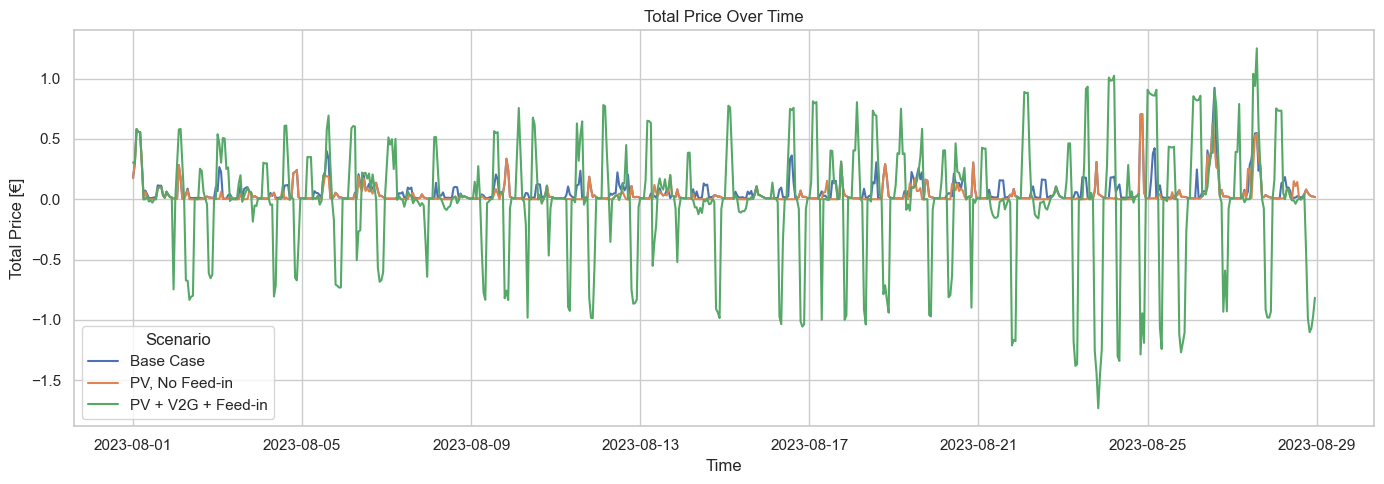

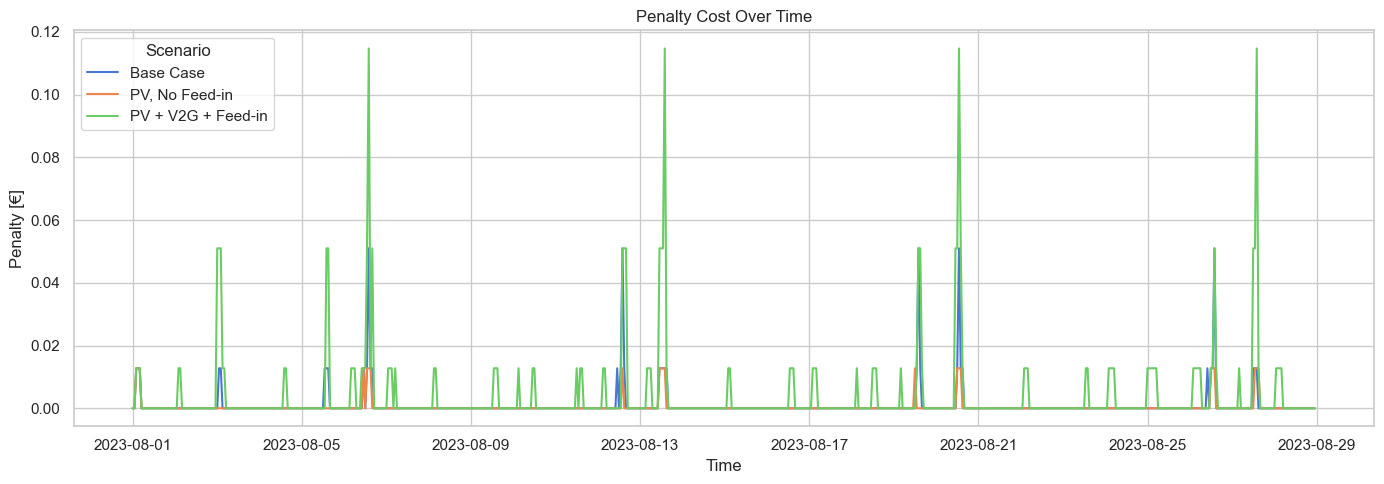

/var/folders/zr/7bf2xpyx49d4nx1_77v7ygqm0000gn/T/ipykernel_90330/380793745.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined, x='Case', y='Net_Price', palette='pastel')


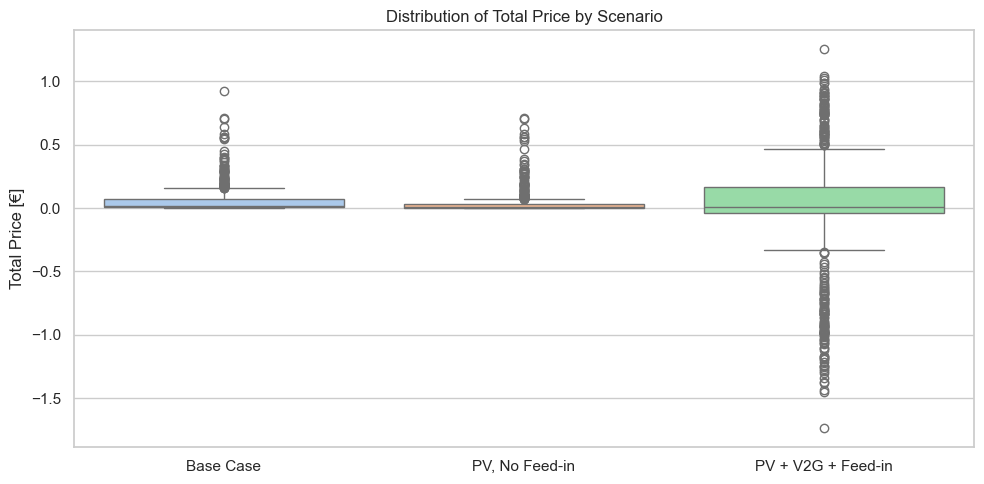

/var/folders/zr/7bf2xpyx49d4nx1_77v7ygqm0000gn/T/ipykernel_90330/380793745.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unmet_total, x='Case', y='Unmet', palette='dark')


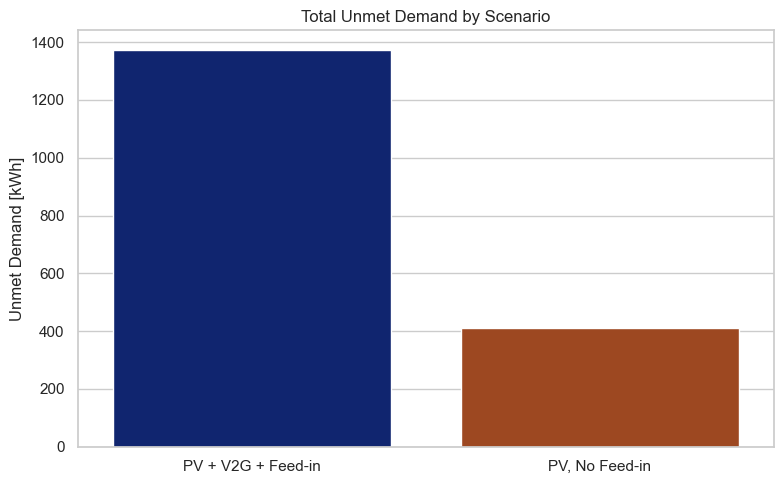

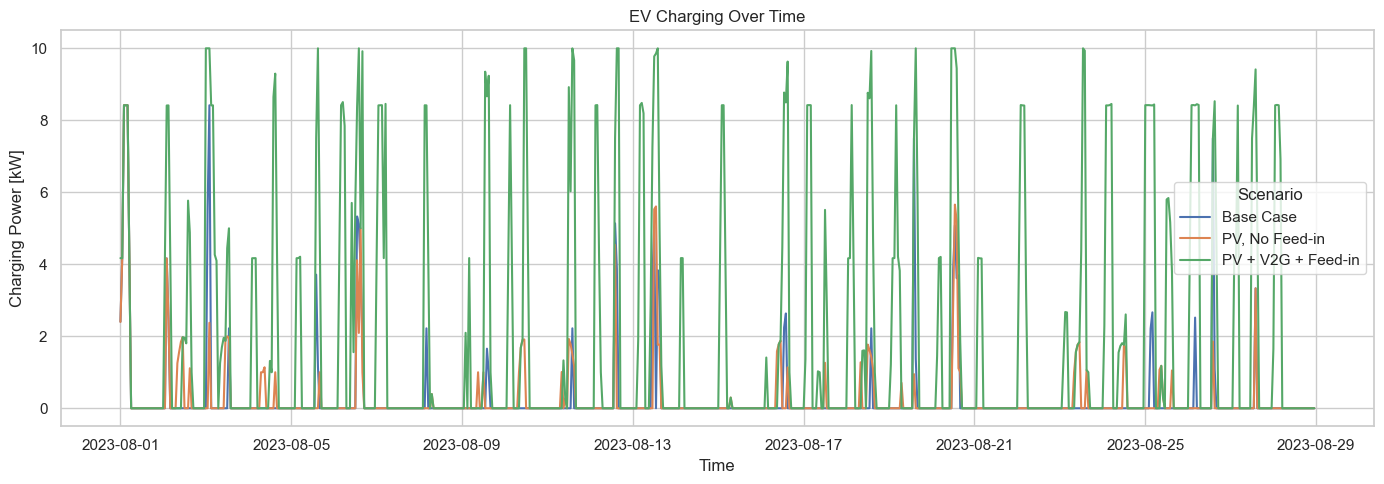

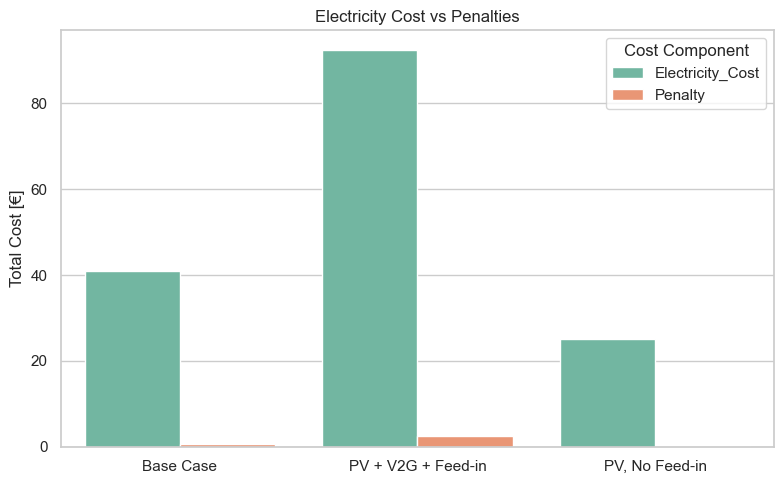

In [5]:
# Set seaborn theme
sns.set_theme(style="whitegrid")

# Add case labels to each DataFrame
results_basecase_summer['Case'] = 'Base Case'
results_case_2_summer['Case'] = 'PV, No Feed-in'
results_case_3_summer['Case'] = 'PV + V2G + Feed-in'

# Normalize column naming for uniformity
results_basecase_summer = results_basecase_summer.rename(columns={'Total_Cost': 'Net_Price', 'Penalty_Cost': 'Penalty'})
results_case_2_summer = results_case_2_summer.rename(columns={'Total_Price': 'Net_Price'})
results_case_3_summer = results_case_3_summer.rename(columns={'Net_Price': 'Net_Price'})

# Combine all into a single DataFrame
combined = pd.concat([results_basecase_summer, results_case_2_summer, results_case_3_summer], ignore_index=True)

# Convert timestamp to datetime (if not already)
combined['timestamp'] = pd.to_datetime(combined['timestamp'])
combined['Hour'] = combined['timestamp'].dt.hour
combined['Day'] = combined['timestamp'].dt.date
combined['Weekday'] = combined['timestamp'].dt.day_name()

# ----- 1. Time Series Plot: Total Price over Time -----
plt.figure(figsize=(14, 5))
sns.lineplot(data=combined, x='timestamp', y='Net_Price', hue='Case', palette='deep')
plt.title('Total Price Over Time')
plt.xlabel('Time')
plt.ylabel('Total Price [€]')
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()

# ----- 2. Time Series Plot: Penalty Cost over Time -----
plt.figure(figsize=(14, 5))
sns.lineplot(data=combined, x='timestamp', y='Penalty', hue='Case', palette='muted')
plt.title('Penalty Cost Over Time')
plt.xlabel('Time')
plt.ylabel('Penalty [€]')
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()

# ----- 3. Distribution Plot: Total Price -----
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined, x='Case', y='Net_Price', palette='pastel')
plt.title('Distribution of Total Price by Scenario')
plt.ylabel('Total Price [€]')
plt.xlabel('')
plt.tight_layout()
plt.show()

# ----- 4. Bar Plot: Total Unmet Demand (only where available) -----
unmet_df = combined.dropna(subset=['Unmet'])
unmet_total = unmet_df.groupby('Case')['Unmet'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=unmet_total, x='Case', y='Unmet', palette='dark')
plt.title('Total Unmet Demand by Scenario')
plt.ylabel('Unmet Demand [kWh]')
plt.xlabel('')
plt.tight_layout()
plt.show()

# ----- 5. EV Charging Pattern -----
plt.figure(figsize=(14, 5))
sns.lineplot(data=combined, x='timestamp', y='EV_Charging', hue='Case', linewidth=1.5)
plt.title('EV Charging Over Time')
plt.ylabel('Charging Power [kW]')
plt.xlabel('Time')
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()

# ----- 6. Energy Cost Breakdown -----
cost_components = ['Electricity_Cost', 'Penalty']
summary = combined.groupby('Case')[cost_components].sum().reset_index()
summary_melted = summary.melt(id_vars='Case', var_name='Component', value_name='Cost')

plt.figure(figsize=(8, 5))
sns.barplot(data=summary_melted, x='Case', y='Cost', hue='Component', palette='Set2')
plt.title('Electricity Cost vs Penalties')
plt.ylabel('Total Cost [€]')
plt.xlabel('')
plt.legend(title='Cost Component')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.dates as mdates

import matplotlib.dates as mdates

def plot_energy_profile(
    results_df,
    title="Energy Profile",
    save_filename="energy_profile.png",
    max_time=24 * 7,  # Default to one week
    power_dishwasher=1.5,
    power_wm=3,
    power_dryer=3,):

    # Ensure timestamp column is in datetime format
    results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
    timestamps = results_df['timestamp'][:max_time]
    time_range = range(0, max_time)
    
    # Extract relevant signals

    binary_dishwasher = results_df['Dishwasher_On']
    binary_wm = results_df['Washing_Machine_On']
    binary_dryer = results_df['Dryer_On']
    soc_ev = results_df['EV_SOC']
    spot_price = results_df['Spotmarket_(EUR/kWh)']
    inflex_demand = results_df['Inflexible_Demand_(kWh)']
    charging_ev = results_df['EV_Charging']
    
    # Build power demand DataFrame
    data_power = pd.DataFrame({
        'timestamp': timestamps,
        'Inflexible Demand': [inflex_demand[t] for t in time_range],
        'Dishwasher': [power_dishwasher * binary_dishwasher[t] for t in time_range],
        'Washing Machine': [power_wm * binary_wm[t] for t in time_range],
        'Dryer': [power_dryer * binary_dryer[t] for t in time_range],
        'EV Charging': [charging_ev[t] for t in time_range]
    })

    if "Heatpump_Power" in results_df.columns:
        data_power['Heat Pump'] = [results_df["Heatpump_Power"][t] for t in time_range]

    data_power_melted = data_power.melt(id_vars='timestamp', var_name='Technology', value_name='Power (kWh)')
    palette = sns.color_palette("tab10", n_colors=len(data_power_melted['Technology'].unique()))

    plt.rcParams.update({
        'axes.titlesize': 16,
        'axes.labelsize': 11,
        'legend.fontsize': 11,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11
    })

    fig, ax1 = plt.subplots(figsize=(14, 7))
    sns.lineplot(data=data_power_melted, x='timestamp', y='Power (kWh)', hue='Technology', ax=ax1, palette=palette, drawstyle='steps-post')

    ax1.set_ylabel("Hourly Energy Demand (kWh)")
    ax1.set_xlabel("Day")
    ax1.set_xlim(timestamps.iloc[0].normalize(), timestamps.iloc[-1].normalize() + pd.Timedelta(days=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())

    # Spotmarket price
    ax2 = ax1.twinx()
    ax2.plot(timestamps, spot_price[:max_time], 'r--', label='Spotmarket Price')
    ax2.set_ylabel("Spotmarket Price (EUR/kWh)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # EV SOC
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(timestamps, soc_ev[:max_time] / 70, 'g:', label='EV SOC')
    ax3.set_ylabel("EV SOC", color='black')
    ax3.tick_params(axis='y', labelcolor='black')

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()

    legend = ax1.legend(
        lines1 + lines2 + lines3,
        labels1 + labels2 + labels3,
        loc='upper right',
        fontsize=9,
        labelspacing=0.3,
        borderpad=0.3,
        handlelength=1.2,
        handletextpad=0.4,
        borderaxespad=0.5,
        fancybox=True,
        facecolor='#f9f9f9',
    )
    legend.get_frame().set_alpha(0.9)

    plt.title(title)
    plt.tight_layout()
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)

    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()

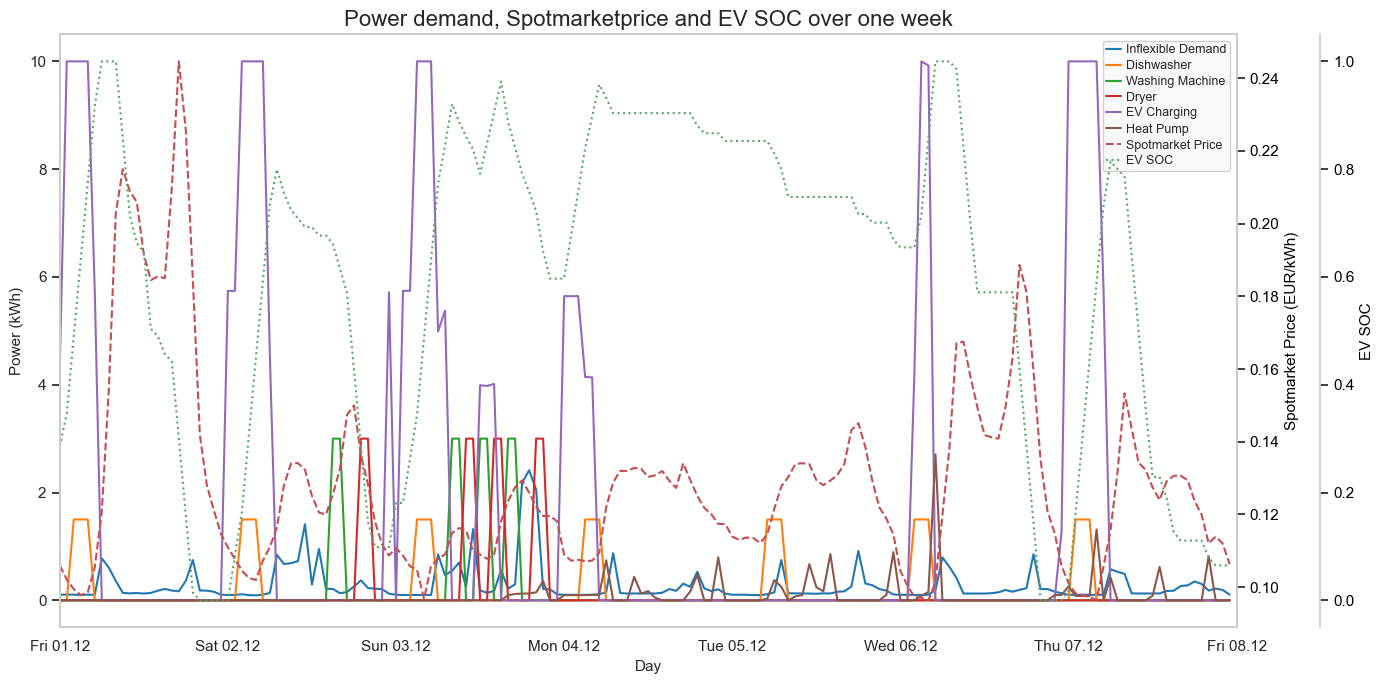

In [ ]:
plot_title = "Weekly SOC EV for diffferent cases"

filename = "SOC_different cases_summer.png"

plot_energy_profile(
    results_df=results_basecase_summer,
    title=plot_title,
    save_filename= filename,
    max_time=24 * 7,
)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# Load CSVs if needed:
# results_basecase_summer = pd.read_csv("path/to/basecase.csv")
# results_case_1_summer = pd.read_csv("path/to/case1.csv")
# results_case_2_summer = pd.read_csv("path/to/case2.csv")
# results_case_3_summer = pd.read_csv("path/to/case3.csv")

def plot_ev_soc_all_cases(
    df_dict,
    title="Weekly EV SOC for Different Cases",
    save_filename="SOC_different_cases_summer.png",
    max_time=24 * 7,
):
    plt.figure(figsize=(14, 6))

    for label, df in df_dict.items():
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        plt.plot(
            df['timestamp'][:max_time],
            df['EV_SOC'][:max_time],
            label=label,
            linewidth=2
        )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("State of Charge (SOC)")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=300)
    else:
        plt.savefig(save_filename, dpi=300)
        
    plt.show()


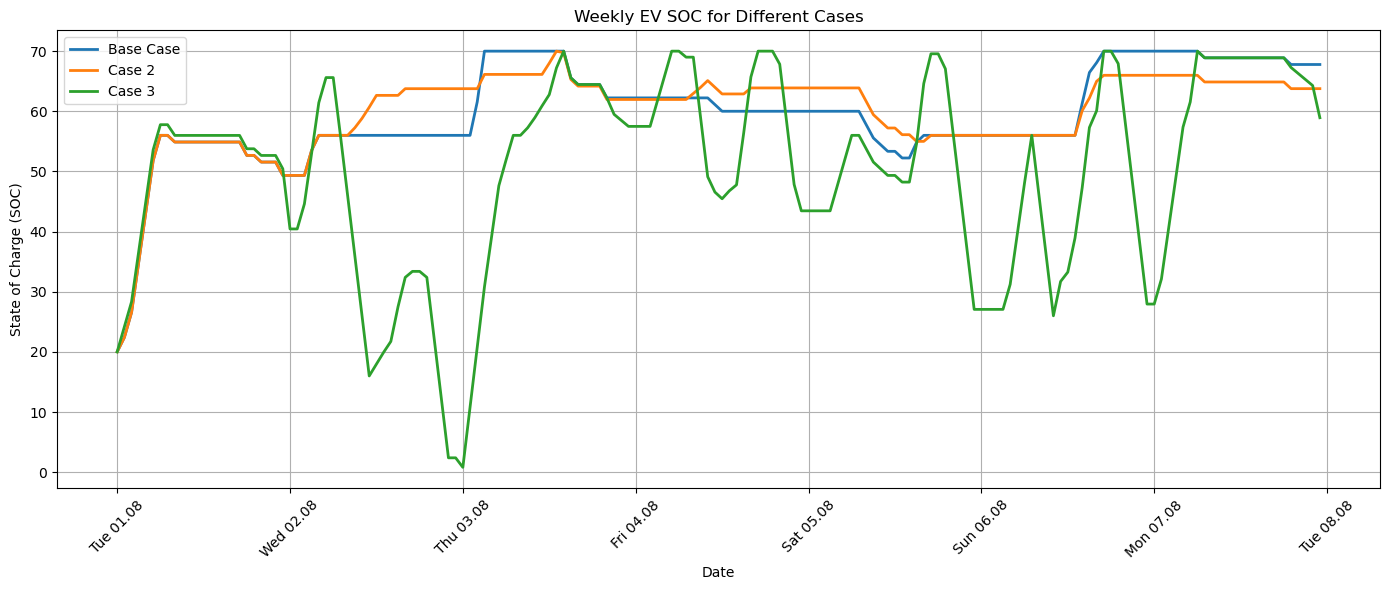

In [7]:


# Dict of all result DataFrames and labels
df_dict = {
    "Base Case": results_basecase_summer,
    #"Case 1": results_case_1_summer,
    "Case 2": results_case_2_summer,
    "Case 3": results_case_3_summer,
}

# Call the function
plot_ev_soc_all_cases(df_dict)


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

def plot_ev_soc_with_price_and_pv(
    df_dict,
    title="Weekly EV SOC with Spot Prices and PV Generation",
    save_filename="SOC_with_price_and_pv.png",
    max_time=24 * 7,
):
    # Use base case for spot price and PV generation reference
    base_df = df_dict["Base Case"]
    base_df['timestamp'] = pd.to_datetime(base_df['timestamp'])

    timestamps = base_df['timestamp'][:max_time]
    #spot_price = base_df['Spotmarket_(EUR/kWh)'][:max_time]
    pv_generation = base_df['PV_energy_production_kWh'][:max_time] if 'PV_energy_production_kWh' in base_df.columns else [0] * max_time

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot SOC for each case
    for label, df in df_dict.items():
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        ax1.plot(
            df['timestamp'][:max_time],
            df['EV_SOC'][:max_time],
            label=label,
            linewidth=2
        )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("State of Charge (SOC)")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True)

    # PV Generation (third y-axis, offset to the right)
    ax2 = ax1.twinx()
    ax2.plot(timestamps, pv_generation, 'r--', label="Spot Price", linewidth=1.5)
    ax2.set_ylabel("Spot Price (EUR/kWh)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Legend (combine handles from all axes)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines3, labels3 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines3,
        labels1 + labels3,
        loc='upper left',
        fontsize=9
    )

    plt.title(title)
    plt.tight_layout()

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=300)
    else:
        plt.savefig(save_filename, dpi=300)

    plt.show()





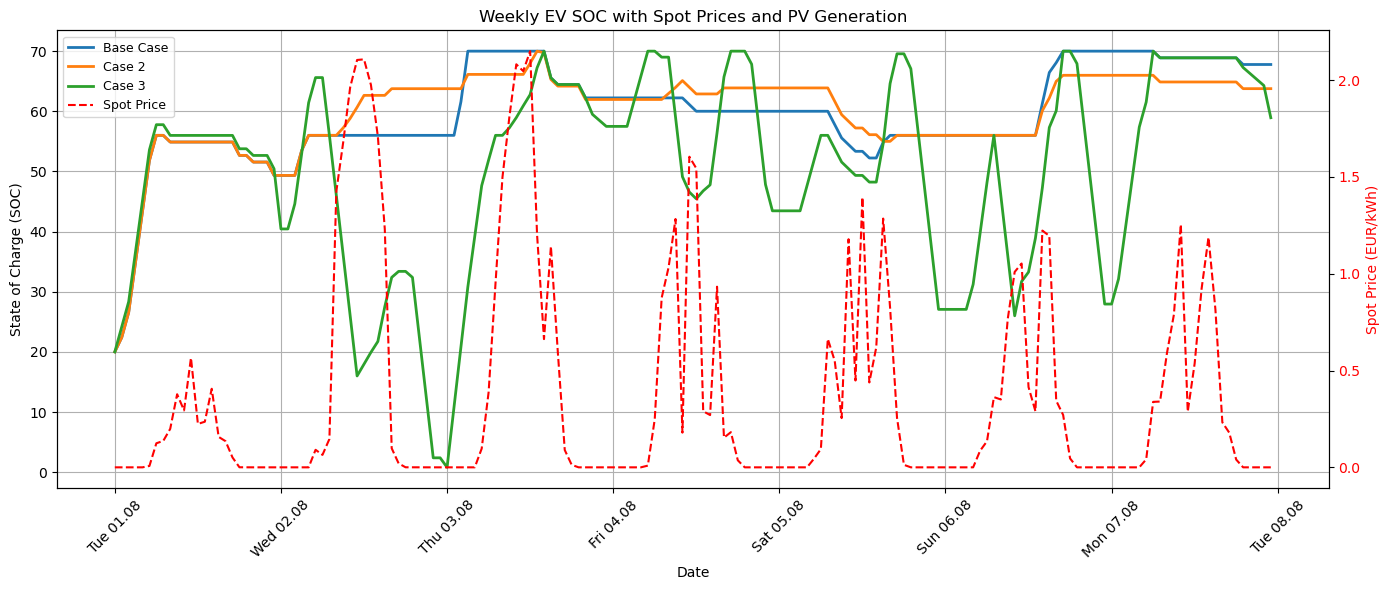

In [19]:
# Example use:
df_dict = {
    "Base Case": results_basecase_summer,
    #"Case 1": results_case_1_summer,
    "Case 2": results_case_2_summer,
    "Case 3": results_case_3_summer,
}

plot_ev_soc_with_price_and_pv(df_dict)

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_case3_load_components(
    df,
    title="Case 3 - Load Components Overview",
    save_filename="case3_load_components.png",
    max_time=24 * 7,
):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    timestamps = df['timestamp'][:max_time]

    # Extract relevant series (adjust column names as needed)
    total_load = df['Total_Load'][:max_time]
    flexible_load = df['Flexible_Load'][:max_time]
    pv_to_home = df['PV_to_Home'][:max_time]
    ev_v2h = df['EV_V2H'][:max_time]
    unmet = df['Unmet'][:max_time]

    plt.figure(figsize=(14, 6))

    plt.plot(timestamps, total_load, label='Total Load', linewidth=2)
    plt.plot(timestamps, flexible_load, label='Flexible Load', linewidth=2)
    plt.plot(timestamps, pv_to_home, label='PV to Home', linestyle='--', linewidth=2)
    plt.plot(timestamps, ev_v2h, label='EV V2H', linestyle='--', linewidth=2)
    plt.plot(timestamps, unmet, label='Unmet Demand', linestyle=':', linewidth=2, color='red')

    plt.xlabel("Date")
    plt.ylabel("Power (kWh)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.tight_layout()

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=300)
    else:
        plt.savefig(save_filename, dpi=300)

    plt.show()

# Example usage
plot_case3_load_components(results_case_3_summer)


KeyError: 'EV_V2H'